In [2]:
# 05_sp500_cs_tree_robustness.ipynb
# Robustness of cross-sectional SP500 tree vs momentum across multiple test windows

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import optuna
from sklearn.ensemble import HistGradientBoostingRegressor

plt.style.use("seaborn-v0_8-darkgrid")

def sharpe_ratio_np(returns, freq: int = 252) -> float:
    """Simple annualized Sharpe on a 1D array of daily returns."""
    r = np.asarray(returns, dtype=float)
    if r.size == 0 or np.isclose(r.std(), 0.0):
        return 0.0
    return np.sqrt(freq) * r.mean() / r.std()


C:\Users\gehra\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)

%load_ext autoreload
%autoreload 2

from src.data_loading_cross import load_sp500_adj_close
from src.signals_cross import (
    make_cross_sectional_signals,
    build_cross_sectional_matrix,
    CROSS_FEATURES,
)

from src.backtest import (
    equity_curve_from_returns,
    cagr,
    annualized_vol,
    sharpe_ratio,
    max_drawdown,
)


PROJECT_ROOT: c:\Users\gehra\Documents\GitHub\Quant_coding


In [4]:
# --- Global transaction cost setting ---
# round-trip cost as a fraction of notional per 21-day "trade"
# 0.0005 = 5 bps, 0.001 = 10 bps, etc.
COST_BPS = 0.001  # tweak this to whatever you want to assume


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6530 entries, 2000-01-03 to 2025-12-17
Columns: 453 entries, NVDA to NWS
dtypes: float64(453)
memory usage: 22.6 MB
Price panel shape: (6530, 453)
Date range: 2000-01-03 00:00:00 -> 2025-12-17 00:00:00
Number of tickers: 453


c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:47: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_1 = prices.pct_change(1)
c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:48: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_5 = prices.pct_change(5)
c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:49: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill N

Signals shape: (2505045, 12)
Columns: ['ret_1', 'ret_5', 'ret_10', 'ret_21', 'vol_10', 'vol_20', 'vol_60', 'ma20_rel', 'ma50_rel', 'ma200_rel', 'target_fwd_21', 'dow']
Signals date range: 2000-10-16 00:00:00 -> 2025-11-17 00:00:00
Unique tickers in signals: 451
X shape: (2505045, 11)
y shape: (2505045,)
Feature names: ['ret_1', 'ret_5', 'ret_10', 'ret_21', 'vol_10', 'vol_20', 'vol_60', 'ma20_rel', 'ma50_rel', 'ma200_rel', 'dow']
Min/max date: 2000-10-16 00:00:00 -> 2025-11-17 00:00:00
Num unique tickers: 451


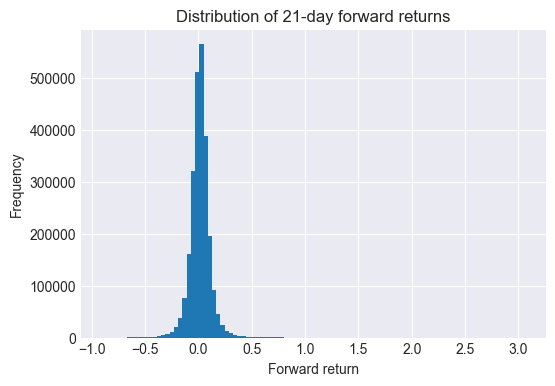

In [5]:
# Load SP500 panel as long as we can reasonably go
# (set force_download=True the first time if needed)
prices = load_sp500_adj_close(start="2000-01-01")

prices.info()
print("Price panel shape:", prices.shape)
print("Date range:", prices.index.min(), "->", prices.index.max())
print("Number of tickers:", len(prices.columns))

lookahead = 21  # ~1 month forward return

signals_df = make_cross_sectional_signals(prices, lookahead=lookahead)

print("Signals shape:", signals_df.shape)
print("Columns:", signals_df.columns.tolist())

dates_all = signals_df.index.get_level_values("date")
tickers_all = signals_df.index.get_level_values("ticker")

print("Signals date range:", dates_all.min(), "->", dates_all.max())
print("Unique tickers in signals:", len(np.unique(tickers_all)))

# Build big (X, y, dates, tickers) matrix
X, y, dates, tickers = build_cross_sectional_matrix(signals_df)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Feature names:", CROSS_FEATURES)
print("Min/max date:", dates.min(), "->", dates.max())
print("Num unique tickers:", np.unique(tickers).size)

# Quick sanity check on forward-return distribution
plt.figure(figsize=(6, 4))
plt.hist(y, bins=100)
plt.title(f"Distribution of {lookahead}-day forward returns")
plt.xlabel("Forward return")
plt.ylabel("Frequency")
plt.show()


In [6]:
def daily_momentum_cs(
    group: pd.DataFrame,
    q: float = 0.1,
    horizon: int = 21,
    cost_bps: float = 0.0,
) -> pd.Series:
    """
    Cross-sectional momentum for a single date.

    group: rows for one date, many tickers.
    q: top/bottom quantile, e.g. 0.1 for deciles.
    horizon: forward horizon used for the target (e.g. 21 days).
    cost_bps: round-trip cost per 21-day position.
    """
    n = len(group)
    if n < 10:
        return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

    # equal-weight all stocks -> "index" (21-day return, frictionless)
    eqw_ret_21 = group["target_fwd_21"].mean()

    # sort by past 21d return (classical cross-sectional momentum)
    g_sorted = group.sort_values("ret_21")
    k = max(1, int(n * q))

    bottom = g_sorted.iloc[:k]
    top    = g_sorted.iloc[-k:]

    long_ret_21  = top["target_fwd_21"].mean()
    short_ret_21 = bottom["target_fwd_21"].mean()
    long_short_21 = long_ret_21 - short_ret_21

    # Apply transaction costs on 21-day horizon
    if cost_bps > 0.0:
        long_ret_21   = (1.0 + long_ret_21) * (1.0 - cost_bps) - 1.0
        long_short_21 = (1.0 + long_short_21) * (1.0 - 2.0 * cost_bps) - 1.0

    # convert to daily
    def to_daily(R):
        return (1.0 + R) ** (1.0 / horizon) - 1.0

    eqw_ret_daily    = to_daily(eqw_ret_21)
    long_ret_daily   = to_daily(long_ret_21)
    long_short_daily = to_daily(long_short_21)

    return pd.Series(
        {
            "eqw": eqw_ret_daily,
            "long": long_ret_daily,
            "long_short": long_short_daily,
        }
    )


def compute_cs_daily_returns(
    df: pd.DataFrame,
    q: float = 0.1,
    horizon: int = 21,
    cost_bps: float = 0.0,
):
    """
    df: index (date, symbol), columns: y_true, y_pred (21d fwd returns + predictions)
    Returns three Series of *daily-equivalent* returns:
        eqw, long-only (top q), long-short (top q minus bottom q)

    cost_bps:
        round-trip transaction cost per 21-day holding period as fraction
        e.g. 0.0005 = 5 bps, 0.001 = 10 bps.
        Applied once for a long-only position and twice for a long-short position.
    """

    def _per_date(group: pd.DataFrame) -> pd.Series:
        n = len(group)
        if n < 10:
            return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

        # Equal-weight all stocks -> benchmark (frictionless)
        eqw_ret_21 = group["y_true"].mean()

        # Sort by predicted forward return
        g_sorted = group.sort_values("y_pred")
        k = max(1, int(n * q))

        bottom = g_sorted.iloc[:k]     # worst predicted
        top    = g_sorted.iloc[-k:]    # best predicted

        long_ret_21  = top["y_true"].mean()
        short_ret_21 = bottom["y_true"].mean()

        long_short_21 = long_ret_21 - short_ret_21

        # apply transaction costs
        if cost_bps > 0.0:
            long_ret_21   = (1.0 + long_ret_21) * (1.0 - cost_bps) - 1.0
            long_short_21 = (1.0 + long_short_21) * (1.0 - 2.0 * cost_bps) - 1.0

        def to_daily(R):
            return (1.0 + R) ** (1.0 / horizon) - 1.0

        eqw_daily        = to_daily(eqw_ret_21)
        long_daily       = to_daily(long_ret_21)
        long_short_daily = to_daily(long_short_21)

        return pd.Series(
            {"eqw": eqw_daily, "long": long_daily, "long_short": long_short_daily}
        )

    daily = df.groupby("date").apply(_per_date)

    eqw = daily["eqw"].astype(float)
    long = daily["long"].astype(float)
    long_short = daily["long_short"].astype(float)

    return eqw, long, long_short


In [7]:
def compute_cs_daily_returns_gated(
    df: pd.DataFrame,
    q: float = 0.1,
    horizon: int = 21,
    cost_bps: float = 0.0,
):
    """
    Like compute_cs_daily_returns, but:
    - uses model predictions to decide whether to trade at all,
    - only applies costs on days where we actually trade.

    df: index (date, symbol), columns: y_true, y_pred
    """

    def _per_date(group: pd.DataFrame) -> pd.Series:
        n = len(group)
        if n < 10:
            return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

        # Benchmark: equal-weight all stocks (no costs)
        eqw_ret_21 = group["y_true"].mean()

        # Rank by predicted forward return
        g_sorted = group.sort_values("y_pred")
        k = max(1, int(n * q))

        bottom = g_sorted.iloc[:k]
        top    = g_sorted.iloc[-k:]

        # --- True 21d returns (what actually happens) ---
        long_true_21  = top["y_true"].mean()
        short_true_21 = bottom["y_true"].mean()
        long_short_true_21 = long_true_21 - short_true_21

        # --- Predicted 21d returns (model view) ---
        long_pred_21  = top["y_pred"].mean()
        short_pred_21 = bottom["y_pred"].mean()
        long_short_pred_21 = long_pred_21 - short_pred_21

        # ---- Decision: do we trade? ----
        # Long-only: require predicted edge > cost
        trade_long = long_pred_21 > cost_bps

        # Long-short: require predicted spread > 2 * cost
        trade_ls   = long_short_pred_21 > 2.0 * cost_bps

        # Start from "no trade"
        long_ret_21      = 0.0
        long_short_21    = 0.0

        if trade_long:
            long_ret_21 = long_true_21

        if trade_ls:
            long_short_21 = long_short_true_21

        # ---- Apply costs only if we actually trade ----
        if cost_bps > 0.0 and trade_long:
            long_ret_21 = (1.0 + long_ret_21) * (1.0 - cost_bps) - 1.0

        if cost_bps > 0.0 and trade_ls:
            long_short_21 = (1.0 + long_short_21) * (1.0 - 2.0 * cost_bps) - 1.0

        # Convert 21-day returns to daily-equivalent
        def to_daily(R):
            return (1.0 + R) ** (1.0 / horizon) - 1.0

        eqw_daily        = to_daily(eqw_ret_21)
        long_daily       = to_daily(long_ret_21)
        long_short_daily = to_daily(long_short_21)

        return pd.Series(
            {"eqw": eqw_daily, "long": long_daily, "long_short": long_short_daily}
        )

    daily = df.groupby("date").apply(_per_date)

    eqw = daily["eqw"].astype(float)
    long = daily["long"].astype(float)
    long_short = daily["long_short"].astype(float)

    return eqw, long, long_short


In [8]:
def run_cs_window(
    test_start: str,
    test_end: str,
    X: np.ndarray,
    y: np.ndarray,
    dates: pd.Series,
    tickers: np.ndarray,
    signals_df: pd.DataFrame,
    n_trials: int = 10,
    q_mom: float = 0.1,
    random_state: int = 42,
):
    """
    Run the full pipeline for a single test window:
    - Train/val on data *before* test_start
    - Tune tree + q on validation long-short Sharpe (net of costs)
    - Evaluate momentum and tree on [test_start, test_end]
    """
    test_start = pd.Timestamp(test_start)
    test_end   = pd.Timestamp(test_end)

    # Masks for this window
    test_mask = (dates >= test_start) & (dates <= test_end)
    hist_mask = dates < test_start

    if test_mask.sum() == 0 or hist_mask.sum() < 1000:
        print(f"Skipping window {test_start.date()}–{test_end.date()} (not enough data).")
        return None

    hist_dates = np.array(sorted(dates[hist_mask].unique()))
    # 70/30 split of *history* into train/val
    train_end_local = hist_dates[int(len(hist_dates) * 0.7)]

    train_mask = (dates <= train_end_local)
    val_mask   = (dates > train_end_local) & (dates < test_start)

    X_train, y_train = X[train_mask], y[train_mask]
    X_val,   y_val   = X[val_mask],   y[val_mask]
    X_test,  y_test  = X[test_mask],  y[test_mask]

    dates_val_local    = dates[val_mask]
    dates_test_local   = dates[test_mask]
    tickers_val_local  = tickers[val_mask]
    tickers_test_local = tickers[test_mask]

    print(
        f"Window {test_start.date()}–{test_end.date()} | "
        f"train={len(y_train)}, val={len(y_val)}, test={len(y_test)}"
    )

    # -------------------------
    # Optuna objective for this window
    # -------------------------
    def objective_tree_cs(trial):
        max_depth       = trial.suggest_int("max_depth", 2, 8)
        learning_rate   = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
        max_iter        = trial.suggest_int("max_iter", 100, 500)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 20, 200)
        q               = trial.suggest_float("q", 0.05, 0.3)  # top/bottom 5–30%

        model = HistGradientBoostingRegressor(
            max_depth=max_depth,
            learning_rate=learning_rate,
            max_iter=max_iter,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
        )
        model.fit(X_train, y_train)

        y_pred_val = model.predict(X_val)

        df_val = pd.DataFrame(
            {
                "date":   dates_val_local,
                "symbol": tickers_val_local,
                "y_true": y_val,
                "y_pred": y_pred_val,
            }
        ).set_index(["date", "symbol"]).sort_index()

        # Build portfolios on validation: long-short (NET of costs)
        _, _, long_short_val = compute_cs_daily_returns(
            df_val,
            q=q,
            horizon=lookahead,
            cost_bps=COST_BPS,
        )

        ret_series = long_short_val.replace([np.inf, -np.inf], np.nan).dropna()

        if len(ret_series) < 20:
            return 0.0

        return -sharpe_ratio_np(ret_series.values)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective_tree_cs, n_trials=n_trials)

    print("  Best params:", study.best_params)
    print("  Best val -Sharpe:", study.best_value)

    best_params = study.best_params.copy()
    q_best = best_params.pop("q")

    tree_best = HistGradientBoostingRegressor(
        **best_params,
        random_state=random_state,
    )

    # Train on all history (train+val) before test_start
    hist_mask_full = dates < test_start
    X_hist, y_hist = X[hist_mask_full], y[hist_mask_full]
    tree_best.fit(X_hist, y_hist)

    # -------------------------
    # 1) Momentum baseline on this test window (NET)
    # -------------------------
    idx_dates = signals_df.index.get_level_values("date")
    signals_test = signals_df.loc[
        (idx_dates >= test_start) & (idx_dates <= test_end)
    ].copy()

    daily_mom = signals_test.groupby("date").apply(
        daily_momentum_cs,
        q=q_mom,
        horizon=lookahead,
        cost_bps=COST_BPS,
    )

    eqw_returns   = daily_mom["eqw"].astype(float)
    momL_returns  = daily_mom["long"].astype(float)
    momLS_returns = daily_mom["long_short"].astype(float)

    # -------------------------
    # 2) Tree strategy on this test window (NET)
    # -------------------------
    y_pred_test = tree_best.predict(X_test)

    df_test = pd.DataFrame(
        {
            "date":   dates_test_local,
            "symbol": tickers_test_local,
            "y_true": y_test,
            "y_pred": y_pred_test,
        }
    ).set_index(["date", "symbol"]).sort_index()

    _, treeL_returns, treeLS_returns = compute_cs_daily_returns(
        df_test, q=q_best, horizon=lookahead, cost_bps=COST_BPS
    )

    # -------------------------
    # 3) Equity curves + metrics
    # -------------------------
    eqw_eq     = equity_curve_from_returns(eqw_returns)
    momL_eq    = equity_curve_from_returns(momL_returns)
    momLS_eq   = equity_curve_from_returns(momLS_returns)
    treeL_eq   = equity_curve_from_returns(treeL_returns)
    treeLS_eq  = equity_curve_from_returns(treeLS_returns)

    metrics = {
        "test_start": test_start.date(),
        "test_end":   test_end.date(),

        "momL_cagr":    cagr(momL_eq),
        "momL_sharpe":  sharpe_ratio(momL_returns),
        "momL_max_dd":  max_drawdown(momL_eq),

        "treeL_cagr":   cagr(treeL_eq),
        "treeL_sharpe": sharpe_ratio(treeL_returns),
        "treeL_max_dd": max_drawdown(treeL_eq),

        "momLS_cagr":   cagr(momLS_eq),
        "momLS_sharpe": sharpe_ratio(momLS_returns),
        "momLS_max_dd": max_drawdown(momLS_eq),

        "treeLS_cagr":   cagr(treeLS_eq),
        "treeLS_sharpe": sharpe_ratio(treeLS_returns),
        "treeLS_max_dd": max_drawdown(treeLS_eq),
    }

    # quick plot for this window
    plt.figure(figsize=(9, 4))
    momL_eq.plot(label="Momentum long-only (net)")
    treeL_eq.plot(label="Tree long-only (Optuna, net)")
    plt.legend()
    plt.title(f"Long-only (net of costs): {test_start.date()}–{test_end.date()}")
    plt.show()

    plt.figure(figsize=(9, 4))
    momLS_eq.plot(label="Momentum long-short (net)")
    treeLS_eq.plot(label="Tree long-short (Optuna, net)")
    plt.legend()
    plt.title(f"Long-short (net of costs): {test_start.date()}–{test_end.date()}")
    plt.show()

    return metrics


[I 2025-12-22 10:40:25,016] A new study created in memory with name: no-name-9b27449f-f754-48a6-b71c-f7f959e516a4


Window 2005-01-01–2009-12-31 | train=242459, val=107861, test=459337


[I 2025-12-22 10:41:30,606] Trial 0 finished with value: -1.4635873937383743 and parameters: {'max_depth': 2, 'learning_rate': 0.010965929846585478, 'max_iter': 337, 'min_samples_leaf': 174, 'q': 0.1750617823059526}. Best is trial 0 with value: -1.4635873937383743.
[I 2025-12-22 10:41:43,002] Trial 1 finished with value: -0.5318700764337932 and parameters: {'max_depth': 4, 'learning_rate': 0.12921048876492525, 'max_iter': 101, 'min_samples_leaf': 42, 'q': 0.22532651759049704}. Best is trial 0 with value: -1.4635873937383743.
[I 2025-12-22 10:42:00,162] Trial 2 finished with value: -2.112783512834829 and parameters: {'max_depth': 3, 'learning_rate': 0.12801361701293465, 'max_iter': 242, 'min_samples_leaf': 139, 'q': 0.17378341473979297}. Best is trial 2 with value: -2.112783512834829.
[I 2025-12-22 10:42:20,092] Trial 3 finished with value: -0.23914081387660713 and parameters: {'max_depth': 2, 'learning_rate': 0.024612765389988984, 'max_iter': 373, 'min_samples_leaf': 163, 'q': 0.060557

  Best params: {'max_depth': 3, 'learning_rate': 0.12818477664461417, 'max_iter': 346, 'min_samples_leaf': 197, 'q': 0.13242068112511995}
  Best val -Sharpe: -2.6665673352477315


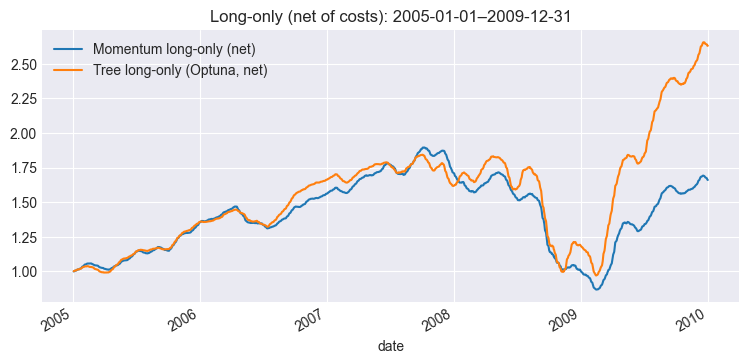

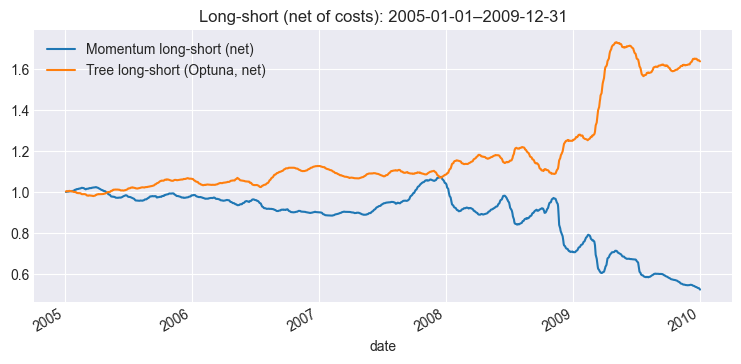

[I 2025-12-22 10:46:14,783] A new study created in memory with name: no-name-e39f2a3a-c7b7-479a-bfa3-6a6904efcc74


Window 2010-01-01–2014-12-31 | train=549813, val=259844, test=501850


[I 2025-12-22 10:47:03,028] Trial 0 finished with value: -3.775925028367562 and parameters: {'max_depth': 3, 'learning_rate': 0.020451145745821426, 'max_iter': 385, 'min_samples_leaf': 90, 'q': 0.09471368722270583}. Best is trial 0 with value: -3.775925028367562.
[I 2025-12-22 10:48:01,136] Trial 1 finished with value: -3.8948750799503737 and parameters: {'max_depth': 4, 'learning_rate': 0.08643218621659085, 'max_iter': 340, 'min_samples_leaf': 156, 'q': 0.22962564517075634}. Best is trial 1 with value: -3.8948750799503737.
[I 2025-12-22 10:48:25,056] Trial 2 finished with value: -3.135861059341976 and parameters: {'max_depth': 8, 'learning_rate': 0.01531493350996378, 'max_iter': 165, 'min_samples_leaf': 55, 'q': 0.19537749922551517}. Best is trial 1 with value: -3.8948750799503737.
[I 2025-12-22 10:48:50,507] Trial 3 finished with value: -4.302141637318815 and parameters: {'max_depth': 7, 'learning_rate': 0.07788607691123611, 'max_iter': 345, 'min_samples_leaf': 143, 'q': 0.1887382759

  Best params: {'max_depth': 6, 'learning_rate': 0.09476388263166617, 'max_iter': 311, 'min_samples_leaf': 142, 'q': 0.15357034990414387}
  Best val -Sharpe: -4.325965716183415


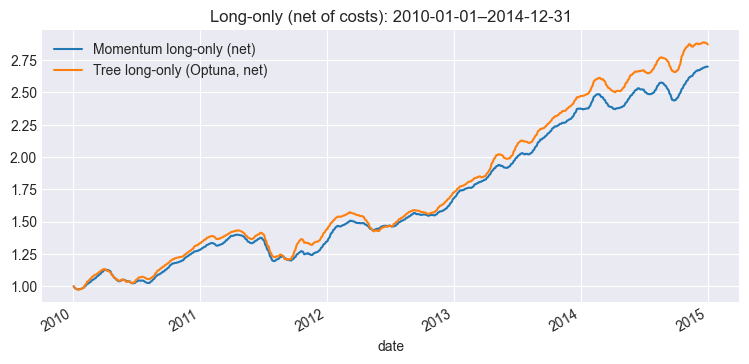

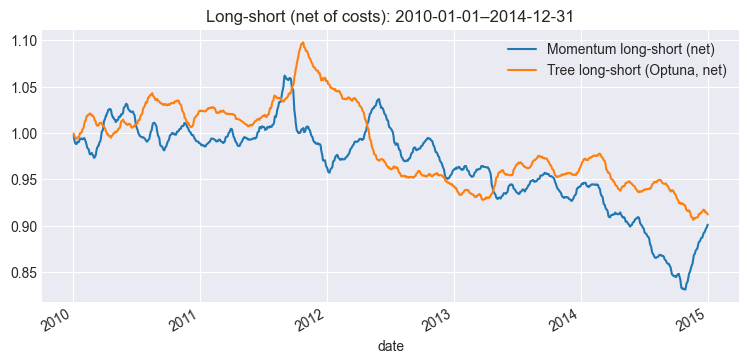

[I 2025-12-22 10:51:36,531] A new study created in memory with name: no-name-e654277e-687f-4bed-96e5-0a21054e7173


Window 2015-01-01–2019-12-31 | train=880883, val=430624, test=536253


[I 2025-12-22 10:52:02,149] Trial 0 finished with value: 1.017236802830107 and parameters: {'max_depth': 2, 'learning_rate': 0.1522776193018676, 'max_iter': 401, 'min_samples_leaf': 85, 'q': 0.2405220503532164}. Best is trial 0 with value: 1.017236802830107.
[I 2025-12-22 10:52:56,741] Trial 1 finished with value: 0.8926305448533384 and parameters: {'max_depth': 6, 'learning_rate': 0.028839144009466057, 'max_iter': 396, 'min_samples_leaf': 190, 'q': 0.19115145919854748}. Best is trial 1 with value: 0.8926305448533384.
[I 2025-12-22 10:53:44,155] Trial 2 finished with value: 0.37706322227460776 and parameters: {'max_depth': 4, 'learning_rate': 0.026109071866716283, 'max_iter': 481, 'min_samples_leaf': 86, 'q': 0.21357290369827053}. Best is trial 2 with value: 0.37706322227460776.
[I 2025-12-22 10:54:53,813] Trial 3 finished with value: -0.14303092633923417 and parameters: {'max_depth': 6, 'learning_rate': 0.01778304959223813, 'max_iter': 482, 'min_samples_leaf': 34, 'q': 0.1084349114744

  Best params: {'max_depth': 5, 'learning_rate': 0.013059517841773161, 'max_iter': 222, 'min_samples_leaf': 34, 'q': 0.10457722227233805}
  Best val -Sharpe: -0.9241684457286587


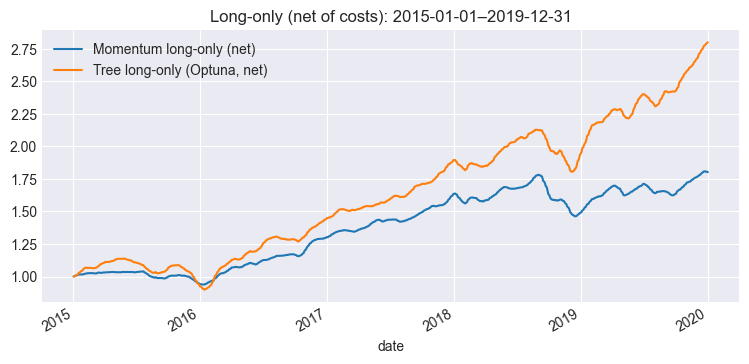

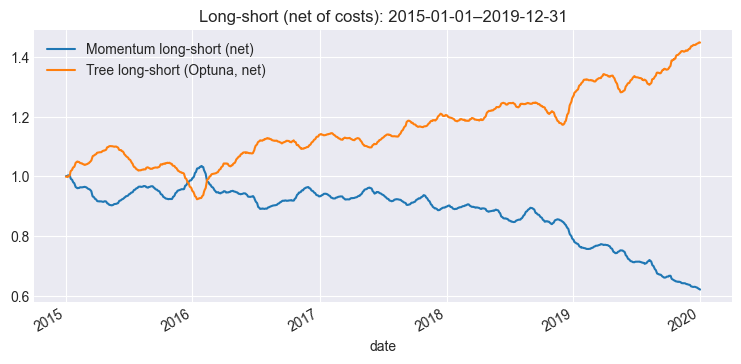

[I 2025-12-22 10:58:32,586] A new study created in memory with name: no-name-bf8c3da1-79ce-4455-b100-7a01d6c5a29c


Window 2020-01-01–2024-12-31 | train=1232188, val=615572, test=558111


[I 2025-12-22 10:59:05,520] Trial 0 finished with value: -1.7655071309692476 and parameters: {'max_depth': 4, 'learning_rate': 0.18434249066659403, 'max_iter': 196, 'min_samples_leaf': 105, 'q': 0.08004159768967391}. Best is trial 0 with value: -1.7655071309692476.
[I 2025-12-22 10:59:21,019] Trial 1 finished with value: -2.921998388868603 and parameters: {'max_depth': 2, 'learning_rate': 0.06463858818912852, 'max_iter': 175, 'min_samples_leaf': 32, 'q': 0.1364074336098216}. Best is trial 1 with value: -2.921998388868603.
[I 2025-12-22 10:59:39,351] Trial 2 finished with value: -2.2760977610950373 and parameters: {'max_depth': 3, 'learning_rate': 0.017725341179822544, 'max_iter': 183, 'min_samples_leaf': 130, 'q': 0.1525660092229979}. Best is trial 1 with value: -2.921998388868603.
[I 2025-12-22 11:00:23,162] Trial 3 finished with value: -2.6068766575324647 and parameters: {'max_depth': 3, 'learning_rate': 0.049682410410943637, 'max_iter': 433, 'min_samples_leaf': 38, 'q': 0.1195390797

  Best params: {'max_depth': 2, 'learning_rate': 0.06463858818912852, 'max_iter': 175, 'min_samples_leaf': 32, 'q': 0.1364074336098216}
  Best val -Sharpe: -2.921998388868603


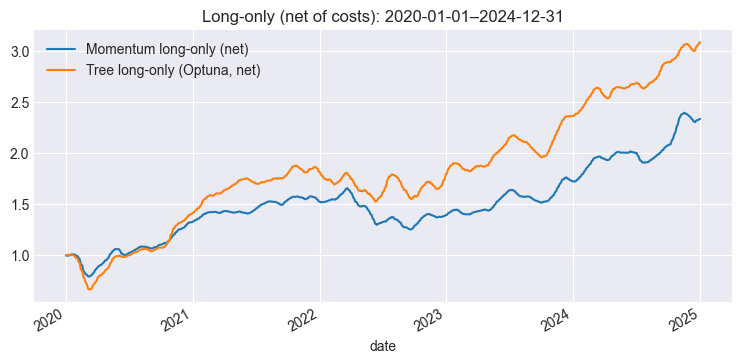

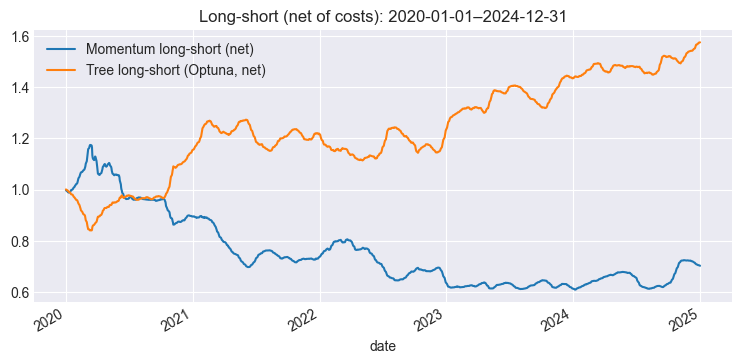

,test_start,test_end,momL_cagr,momL_sharpe,momL_max_dd,treeL_cagr,treeL_sharpe,treeL_max_dd,momLS_cagr,momLS_sharpe,momLS_max_dd,treeLS_cagr,treeLS_sharpe,treeLS_max_dd
0,2005-01-01,2009-12-31,0.106992,1.861044,-0.541993,0.213359,2.886034,-0.473685,-0.121386,-1.875314,-0.511963,0.103107,2.852498,-0.107872
1,2010-01-01,2014-12-31,0.220422,6.471051,-0.146564,0.235460,6.249241,-0.158463,-0.020076,-0.933459,-0.217081,-0.018148,-1.175917,-0.174237
2,2015-01-01,2019-12-31,0.125113,4.379338,-0.179420,0.229068,6.118561,-0.209494,-0.091091,-3.260790,-0.399704,0.077136,2.878668,-0.161595
3,2020-01-01,2024-12-31,0.185737,3.690401,-0.243806,0.253123,3.978441,-0.339301,-0.068187,-1.396745,-0.482553,0.095403,2.526138,-0.160577


In [9]:
test_windows = [
    ("2005-01-01", "2009-12-31"),
    ("2010-01-01", "2014-12-31"),
    ("2015-01-01", "2019-12-31"),
    ("2020-01-01", "2024-12-31"),
]

results = []
for start, end in test_windows:
    print("=" * 80)
    m = run_cs_window(
        start,
        end,
        X=X,
        y=y,
        dates=dates,
        tickers=tickers,
        signals_df=signals_df,
        n_trials=10,
        q_mom=0.1,
    )
    if m is not None:
        results.append(m)

results_df = pd.DataFrame(results)
results_df


In [10]:
summary_cols = [
    "test_start", "test_end",
    "momL_sharpe", "treeL_sharpe",
    "momLS_sharpe", "treeLS_sharpe",
]

summary = results_df[summary_cols].copy()
summary


,test_start,test_end,momL_sharpe,treeL_sharpe,momLS_sharpe,treeLS_sharpe
0,2005-01-01,2009-12-31,1.861044,2.886034,-1.875314,2.852498
1,2010-01-01,2014-12-31,6.471051,6.249241,-0.933459,-1.175917
2,2015-01-01,2019-12-31,4.379338,6.118561,-3.260790,2.878668
3,2020-01-01,2024-12-31,3.690401,3.978441,-1.396745,2.526138


In [11]:
summary["treeL_minus_momL"]   = summary["treeL_sharpe"]  - summary["momL_sharpe"]
summary["treeLS_minus_momLS"] = summary["treeLS_sharpe"] - summary["momLS_sharpe"]

summary


,test_start,test_end,momL_sharpe,treeL_sharpe,momLS_sharpe,treeLS_sharpe,treeL_minus_momL,treeLS_minus_momLS
0,2005-01-01,2009-12-31,1.861044,2.886034,-1.875314,2.852498,1.024990,4.727812
1,2010-01-01,2014-12-31,6.471051,6.249241,-0.933459,-1.175917,-0.221809,-0.242458
2,2015-01-01,2019-12-31,4.379338,6.118561,-3.260790,2.878668,1.739222,6.139458
3,2020-01-01,2024-12-31,3.690401,3.978441,-1.396745,2.526138,0.288040,3.922883


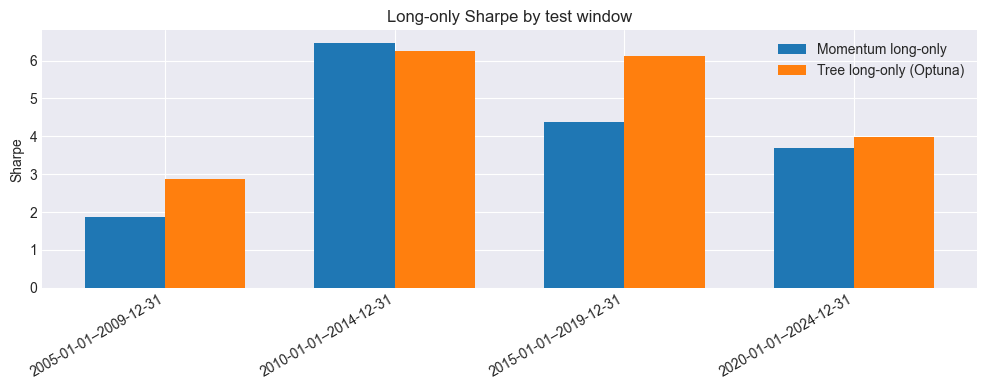

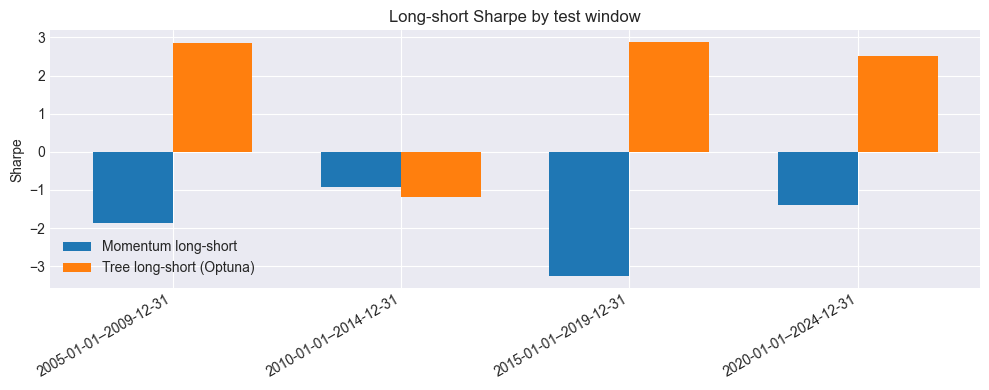

In [12]:
# Nice labels for windows
window_labels = (
    results_df["test_start"].astype(str)
    + "–"
    + results_df["test_end"].astype(str)
)
x = np.arange(len(results_df))
width = 0.35

# --- Long-only Sharpe: momentum vs tree ---
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, results_df["momL_sharpe"], width, label="Momentum long-only")
plt.bar(x + width/2, results_df["treeL_sharpe"], width, label="Tree long-only (Optuna)")
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Sharpe")
plt.title("Long-only Sharpe by test window")
plt.legend()
plt.tight_layout()
plt.show()

# --- Long-short Sharpe: momentum vs tree ---
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, results_df["momLS_sharpe"], width, label="Momentum long-short")
plt.bar(x + width/2, results_df["treeLS_sharpe"], width, label="Tree long-short (Optuna)")
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Sharpe")
plt.title("Long-short Sharpe by test window")
plt.legend()
plt.tight_layout()
plt.show()


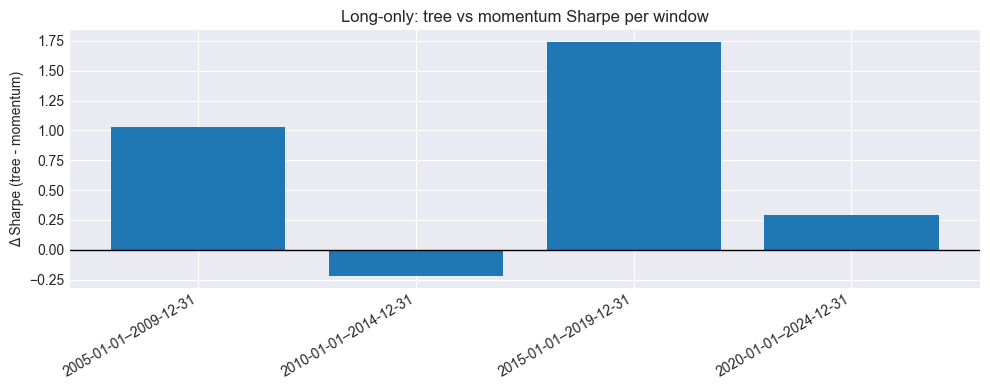

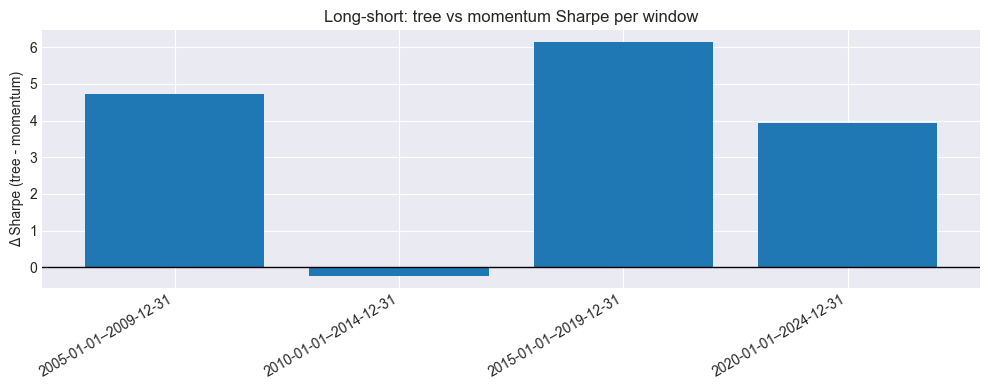

In [13]:
# Add differences if not already there
results_df["treeL_minus_momL"]   = results_df["treeL_sharpe"]  - results_df["momL_sharpe"]
results_df["treeLS_minus_momLS"] = results_df["treeLS_sharpe"] - results_df["momLS_sharpe"]

plt.figure(figsize=(10, 4))
plt.bar(x, results_df["treeL_minus_momL"])
plt.axhline(0, color="black", linewidth=1)
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Δ Sharpe (tree - momentum)")
plt.title("Long-only: tree vs momentum Sharpe per window")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.bar(x, results_df["treeLS_minus_momLS"])
plt.axhline(0, color="black", linewidth=1)
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Δ Sharpe (tree - momentum)")
plt.title("Long-short: tree vs momentum Sharpe per window")
plt.tight_layout()
plt.show()


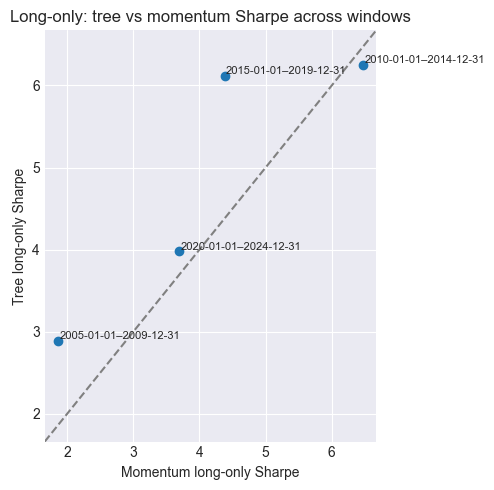

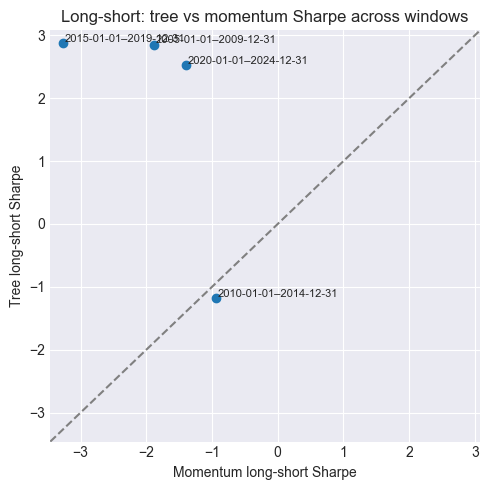

In [14]:
# Long-only scatter
plt.figure(figsize=(5, 5))
plt.scatter(results_df["momL_sharpe"], results_df["treeL_sharpe"])
lims = [
    min(results_df["momL_sharpe"].min(), results_df["treeL_sharpe"].min()) - 0.2,
    max(results_df["momL_sharpe"].max(), results_df["treeL_sharpe"].max()) + 0.2,
]
plt.plot(lims, lims, "--", color="gray")  # y = x line
for i, label in enumerate(window_labels):
    plt.text(
        results_df["momL_sharpe"].iloc[i] + 0.02,
        results_df["treeL_sharpe"].iloc[i] + 0.02,
        label,
        fontsize=8,
    )
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Momentum long-only Sharpe")
plt.ylabel("Tree long-only Sharpe")
plt.title("Long-only: tree vs momentum Sharpe across windows")
plt.tight_layout()
plt.show()

# Long-short scatter
plt.figure(figsize=(5, 5))
plt.scatter(results_df["momLS_sharpe"], results_df["treeLS_sharpe"])
lims = [
    min(results_df["momLS_sharpe"].min(), results_df["treeLS_sharpe"].min()) - 0.2,
    max(results_df["momLS_sharpe"].max(), results_df["treeLS_sharpe"].max()) + 0.2,
]
plt.plot(lims, lims, "--", color="gray")
for i, label in enumerate(window_labels):
    plt.text(
        results_df["momLS_sharpe"].iloc[i] + 0.02,
        results_df["treeLS_sharpe"].iloc[i] + 0.02,
        label,
        fontsize=8,
    )
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Momentum long-short Sharpe")
plt.ylabel("Tree long-short Sharpe")
plt.title("Long-short: tree vs momentum Sharpe across windows")
plt.tight_layout()
plt.show()


In [15]:
# === PAPER TRADING MODE, FOR RESEARCH PURPOSE ONLY: cross-sectional SP500 picks for "tomorrow" ===

from IPython.display import display

TOP_N_LONG = 20   # how many longs to show
TOP_N_SHORT = 20  # how many shorts to show

# 1) Choose as-of date: last date where we have signals/targets
as_of_date = dates.max()
print(f"As-of date for paper trading: {as_of_date.date()}")

# ----- build train / val sets using only history before as_of_date -----
hist_mask = dates < as_of_date
if hist_mask.sum() < 1000:
    raise ValueError("Not enough history before as_of_date for a meaningful model.")

hist_dates = np.array(sorted(dates[hist_mask].unique()))
train_end_live = hist_dates[int(len(hist_dates) * 0.7)]

train_mask_live = (dates <= train_end_live)
val_mask_live   = (dates > train_end_live) & (dates < as_of_date)

X_train_live, y_train_live = X[train_mask_live], y[train_mask_live]
X_val_live,   y_val_live   = X[val_mask_live],   y[val_mask_live]

dates_val_live   = dates[val_mask_live]
tickers_val_live = tickers[val_mask_live]

print(
    f"Live setup | train={len(y_train_live)} samples "
    f"val={len(y_val_live)} samples (all < {as_of_date.date()})"
)

# 2) Optuna objective: tune tree hyperparams + q on long-short Sharpe (net of cost)
def objective_tree_live(trial):
    max_depth       = trial.suggest_int("max_depth", 2, 8)
    learning_rate   = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
    max_iter        = trial.suggest_int("max_iter", 100, 500)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 20, 200)
    q               = trial.suggest_float("q", 0.05, 0.3)  # top/bottom 5–30%

    model = HistGradientBoostingRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        max_iter=max_iter,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
    )
    model.fit(X_train_live, y_train_live)

    y_pred_val = model.predict(X_val_live)

    df_val_live = (
        pd.DataFrame(
            {
                "date":   dates_val_live,
                "symbol": tickers_val_live,
                "y_true": y_val_live,
                "y_pred": y_pred_val,
            }
        )
        .set_index(["date", "symbol"])
        .sort_index()
    )

    # build long/short portfolios on validation (net of transaction costs)
    _, long_val, long_short_val = compute_cs_daily_returns(
        df_val_live,
        q=q,
        horizon=lookahead,
        cost_bps=COST_BPS,
    )

    ret_series = long_short_val.replace([np.inf, -np.inf], np.nan).dropna()
    if len(ret_series) < 20:
        return 0.0  # treat as bad if too little data

    return -sharpe_ratio_np(ret_series.values)  # Optuna MINIMIZES

study_live = optuna.create_study(direction="minimize")
study_live.optimize(objective_tree_live, n_trials=20)

print("Best live params:", study_live.best_params)
print("Best live val -Sharpe:", study_live.best_value)

best_live = study_live.best_params.copy()
q_live = best_live.pop("q")

# 3) Train final tree on ALL history before as_of_date
tree_live = HistGradientBoostingRegressor(
    **best_live,
    random_state=42,
)

X_hist_live = X[hist_mask]
y_hist_live = y[hist_mask]
tree_live.fit(X_hist_live, y_hist_live)

# 4) Predictions for the as-of date (our "today")
live_mask = dates == as_of_date
X_live = X[live_mask]
tickers_live = tickers[live_mask]

y_pred_live = tree_live.predict(X_live)

panel_live = pd.DataFrame(
    {
        "ticker": tickers_live,
        "pred_fwd_21": y_pred_live,   # model prediction: 21d total return (gross)
    }
).set_index("ticker")

# approximate net-of-fee 21d return for a long position
panel_live["pred_fwd_21_net_long"] = (1.0 + panel_live["pred_fwd_21"]) * (1.0 - COST_BPS) - 1.0
panel_live["pred_daily_net_long"] = (1.0 + panel_live["pred_fwd_21_net_long"]) ** (1.0 / lookahead) - 1.0

# cross-sectional average daily net return (like EW benchmark)
mean_daily_net = panel_live["pred_daily_net_long"].mean()
panel_live["edge_vs_eqw_daily"] = panel_live["pred_daily_net_long"] - mean_daily_net

# 5) Sort and show top/bottom N
panel_sorted = panel_live.sort_values("pred_fwd_21_net_long", ascending=False)

top_long  = panel_sorted.head(TOP_N_LONG).copy()
bottom_short = panel_sorted.tail(TOP_N_SHORT).copy()

print("\n=== Paper-trade recommendation ===")
print(f"As-of date: {as_of_date.date()}  |  lookahead: {lookahead} days")
print(
    f"Tuned q_live = {q_live:.3f}  "
    f"(strategy would typically long/short ~{int(q_live * len(panel_sorted))} names per side)"
)
print(f"Assumed round-trip cost: {COST_BPS * 1e4:.1f} bps per 21d holding period")

print("\nTop tickers to LONG (preview, net of costs):")
display(
    top_long[
        ["pred_fwd_21", "pred_fwd_21_net_long", "pred_daily_net_long", "edge_vs_eqw_daily"]
    ].sort_values("pred_fwd_21_net_long", ascending=False)
)

print("\nBottom tickers to SHORT (preview, net of costs):")
# for shorts, a strongly negative predicted return is good
display(
    bottom_short[
        ["pred_fwd_21", "pred_fwd_21_net_long", "pred_daily_net_long", "edge_vs_eqw_daily"]
    ].sort_values("pred_fwd_21_net_long")  # most negative first
)


As-of date for paper trading: 2025-11-17


[I 2025-12-22 11:04:40,954] A new study created in memory with name: no-name-788091f6-b63c-4450-9cc9-d293026d093e


Live setup | train=1668712 samples val=835884 samples (all < 2025-11-17)


[I 2025-12-22 11:05:00,523] Trial 0 finished with value: -2.5415983055214793 and parameters: {'max_depth': 2, 'learning_rate': 0.012956996054616692, 'max_iter': 148, 'min_samples_leaf': 52, 'q': 0.13680019532902316}. Best is trial 0 with value: -2.5415983055214793.
[I 2025-12-22 11:05:33,160] Trial 1 finished with value: -1.1433641814706783 and parameters: {'max_depth': 6, 'learning_rate': 0.042992188354007685, 'max_iter': 176, 'min_samples_leaf': 118, 'q': 0.22441397099873178}. Best is trial 0 with value: -2.5415983055214793.
[I 2025-12-22 11:06:49,459] Trial 2 finished with value: -1.8562276152366841 and parameters: {'max_depth': 6, 'learning_rate': 0.16889789267639013, 'max_iter': 437, 'min_samples_leaf': 149, 'q': 0.05280823564460442}. Best is trial 0 with value: -2.5415983055214793.
[I 2025-12-22 11:07:09,547] Trial 3 finished with value: -2.3142336115388864 and parameters: {'max_depth': 4, 'learning_rate': 0.061509680759730075, 'max_iter': 119, 'min_samples_leaf': 87, 'q': 0.0795

Best live params: {'max_depth': 2, 'learning_rate': 0.023819225329364972, 'max_iter': 100, 'min_samples_leaf': 61, 'q': 0.11178527874905789}
Best live val -Sharpe: -3.193038300679555

=== Paper-trade recommendation ===
As-of date: 2025-11-17  |  lookahead: 21 days
Tuned q_live = 0.112  (strategy would typically long/short ~50 names per side)
Assumed round-trip cost: 10.0 bps per 21d holding period

Top tickers to LONG (preview, net of costs):


,pred_fwd_21,pred_fwd_21_net_long,pred_daily_net_long,edge_vs_eqw_daily
ticker,,,,
MOH,0.034897,0.033862,0.001587,0.000979
ARE,0.026631,0.025604,0.001205,0.000596
MU,0.026163,0.025137,0.001183,0.000574
TER,0.026163,0.025137,0.001183,0.000574
WDC,0.026163,0.025137,0.001183,0.000574
STX,0.026163,0.025137,0.001183,0.000574
WBD,0.025812,0.024786,0.001167,0.000558
AMD,0.025812,0.024786,0.001167,0.000558
CMG,0.025287,0.024262,0.001142,0.000534



Bottom tickers to SHORT (preview, net of costs):


,pred_fwd_21,pred_fwd_21_net_long,pred_daily_net_long,edge_vs_eqw_daily
ticker,,,,
EXC,0.010106,0.009096,0.000431,-0.000177
MRK,0.010106,0.009096,0.000431,-0.000177
EW,0.010106,0.009096,0.000431,-0.000177
CME,0.010106,0.009096,0.000431,-0.000177
MPC,0.010106,0.009096,0.000431,-0.000177
ALL,0.010106,0.009096,0.000431,-0.000177
VLO,0.010106,0.009096,0.000431,-0.000177
SRE,0.010106,0.009096,0.000431,-0.000177
PSX,0.010106,0.009096,0.000431,-0.000177
